<a href="https://colab.research.google.com/github/selimunal/Pytorch/blob/main/88_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from torchvision.utils import save_image
import os

In [ ]:
# min to max values
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5,))
])

In [ ]:
train_dataset =torchvision.datasets.MNIST(
    root=".",
    train=True,
    transform=transform,
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
len(train_dataset)

60000

In [ ]:
#DISCRIMINATOR 

D=nn.Sequential(
    nn.Linear(784,512),
    nn.LeakyReLU(0.2),
    nn.Linear(512,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,1),
    #nn.Sigmoid()
)

In [ ]:
#GENERATOR 

latent_dim=100
G=nn.Sequential(
    nn.Linear(latent_dim,256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256,momentum=0.7),
    nn.Linear(256,512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512,momentum=0.7),
    nn.Linear(512,1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024,momentum=0.7),
    nn.Linear(1024,784),
    nn.Tanh()

)


In [ ]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
D=D.to(device)
G=G.to(device)

In [ ]:
criterion=nn.BCEWithLogitsLoss()
d_optimizer=torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))
g_optimizer=torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))

In [ ]:
#scale image back to 0,1
def scale_image(img):
    out=(img+1) / 2
    return out

In [ ]:
if not os.path.exists("gan_images"):
    os.makedirs("gan_images")

In [ ]:
batch_size=128
data_loader=torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
#training loop

#labels to  use in the loop
ones_=torch.ones(batch_size,1).to(device)
zeros_=torch.zeros(batch_size,1).to(device)

#save loosses
d_losses=[]
g_losses=[]

for epoch in range(200):
    for inputs, _ in data_loader: # NO TARGET IS NEEDED SINCE GAN
        #reshape
        n=inputs.size(0)
        inputs=inputs.reshape(n,784).to(device)

        ones=ones_[:n]
        zeros=zeros_[:n]

        ###### train discriminator ###
        
        #real images
        real_outputs=D(inputs)
        d_loss_real=criterion(real_outputs, ones)

        #fake images
        noise=torch.randn(n, latent_dim).to(device)
        fake_images=G(noise)
        fake_outputs=D(fake_images)
        d_loss_fake=criterion(fake_outputs,zeros)

        #gradient descent

        d_loss=0.5*(d_loss_real+d_loss_fake)
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        ###### train generator ######
        #do it twice

        for _ in range(2):
            #fake images
            noise=torch.randn(n,latent_dim).to(device)
            fake_images=G(noise)
            fake_outputs=D(fake_images)

            #reverse labels
            g_loss=criterion(fake_outputs,ones)

            #gradient descent
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

        #save losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    #print and save
    print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

    #save images to file
    fake_images=fake_images.reshape(-1,1,28,28)
    save_image(scale_image(fake_images),f"gan_images/{epoch+1}.png")


Epich: 199, d_loss: 0.5451967120170593, g_loss: 1.1327400207519531


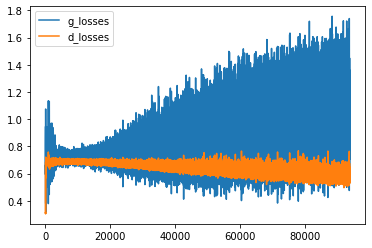

In [ ]:
plt.plot(g_losses, label="g_losses")
plt.plot(d_losses,label="d_losses")
plt.legend()

'/root'